In [172]:
%%HTML
<html>
<h1> Bergfex webscraping
</h1>
<body>We gather information about outdoor sport itineraries from <a href='https://www.bergfex.com/sommer/bern-region/touren/?isAjax=1&page=1'> Bergfex.com </a> in the region of Bern.<br />
    - The website displays 20 tours per page, with infos such as length, type of sport, rating, etc... <br />
    - Most informations are provided by users.<br />
<br />
We then clean the data, and do a bunch of simple analysis.
</body>
</html>

In [86]:
%%HTML
<html>
<h2> Part 1: Data scraping and cleaning
</h2>

</html>

In [87]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [139]:
# initializing the future colums of our dataframe with empty lists

title = []  # Title of the tour
difficulty = []  # difficulty (easy, medium, hard)
sport = []  # Sport type (hiking, sledging, snowshoe...)
length = []  # length in km
time = []  # tour time in hours:minutes
climb = []  # positive elevation climb in m
minmax = []  # minimum and maximum altitude of the tour in m
technique = []  # technique difficulty ratings (out of 6)
fitness = []  # fitness difficulty ratings (out of 6)

# all ratings are stored together so we will need this along the way:
rating = []  # list to store technique and fitness rating info

In [140]:
# looping over the 10 first pages of Bergfex
# each separate tour on the page is framed by a div tag with 'touren-details'

page_number = 20  # number of pages we want to scap through

for p in range(1, (page_number+1)):
    base_link = 'https://www.bergfex.com/sommer/bern-region/touren/?isAjax=1&page='
    link = base_link+str(p)  # going over p pages with numbers appended to the base link
    page = requests.get(link, timeout=5)
    print("scraped page", p)
    soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
    tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

# For each page, we loop over each tour and fill our lists with info     
    for i in range(0,len(tours)):
        tour_1 = tours[i] # tour iterating over the 20 tours of the page

        tour_title = tour_1.findAll('a' ) # this gets the title out
        title.append([info.get_text().strip() for info in tour_title])

        tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) #tour level difficulty
        difficulty.append([info.get_text().strip() for info in tour_diff])

        tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports (should all be hiking)
        sport.append([info.get_text().strip() for info in tour_type])

        tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
        stat_text = [info.get_text().strip() for info in tour_stats]
        length.append(stat_text[0])
        time.append(stat_text[1])
        climb.append(stat_text[2])
        minmax.append(stat_text[3])
        
        tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
        rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.

scraped page 1
scraped page 2
scraped page 3
scraped page 4
scraped page 5
scraped page 6
scraped page 7
scraped page 8
scraped page 9
scraped page 10
scraped page 11
scraped page 12
scraped page 13
scraped page 14
scraped page 15
scraped page 16
scraped page 17
scraped page 18
scraped page 19
scraped page 20


In [141]:
print("number of tours collected:", len(title))

number of tours collected: 400


In [142]:
# Dealing with the ratings for fitness and technique
# we need to extract Rating data which is "embedded" as a class name in the bs4.BeautifulSoup
rating[0]

[<div class="tour-rating">
 <div class="tour-rating-label">Technique</div>
 <div class="rating-circles rating-max6"><div class="rating-4"></div></div>
 </div>,
 <div class="tour-rating">
 <div class="tour-rating-label">Fitness</div>
 <div class="rating-circles rating-max6"><div class="rating-3"></div></div>
 </div>]

In [143]:
# converting into string
tour_rating_str = str(rating)

# taking out unnecessary info - each second rating is Technique or Fitness, starting with technique
rating_all_short = tour_rating_str.replace('<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n<div class="rating-circles rating-max6"><div class="','').replace('<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n<div class="rating-circles rating-max6"><div class="','').replace('"></div></div>\n</div>',"")
rating_even_shorter = rating_all_short.replace('[','').replace(']','')


## splitting into lists
rating_list = rating_even_shorter.split(", ")

In [144]:
# filling the lists technique = [] and fitness = []  we defined in the beginning

for i in range(0,(len(rating_list))):
    if i == 0:
        technique.append(rating_list[i]) # first item goes into technique
    elif i % 2 == 0:
        technique.append(rating_list[i]) # then every second item as well
    else:
        fitness.append(rating_list[i]) # the other items go into fitness

In [145]:
# Forming a dataframe from our lists as columns:

hikes_df = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })

In [146]:
#  First draft dataframe: brackets, units, minmax to separate
hikes_df

,title,difficulty,sport,length,time,climb,minmax,technique,fitness
0,[Den Sonnenaufgang am Hohgant erleben],[medium],[Hiking],14.92km,05:15h,640hm,"1,558 - 2,164m",rating-4,rating-3
1,[Eggli Run],[easy],[Sledge],6.37km,01:30h,4hm,"1,041 - 1,558m",rating-2,rating-2
2,[Wasserfall Sprutz Loop (3h30)],[medium],[Hiking],6.75km,03:30h,456hm,"1,417 - 1,815m",rating-3,rating-2
3,[Zur Gletscher-Arena an der kontinentalen Wass...,[medium],[Hiking],8.53km,04:00h,700hm,"2,161 - 2,664m",rating-3,rating-4
4,[Mit Blick auf das ewige Eis],[difficult],[Hiking],8.55km,05:30h,"1,740hm","1,343 - 3,074m",rating-4,rating-5
...,...,...,...,...,...,...,...,...,...
395,[Auf dem Schnitzlerweg von der Axalp zum Hinte...,[easy],[Thematic route],6.57km,02:30h,387hm,"1,419 - 1,723m",rating-1,rating-2
396,[Mürren - Sonnenberg - Allmendhubel],[easy],[Winter hiking],2.05km,01:00h,278hm,"1,638 - 1,909m",rating-2,rating-2
397,[Vom Urbachtal zur Gaulihütte],[difficult],[Hiking],16.72km,07:00h,"1,486hm","875 - 2,241m",rating-3,rating-6
398,[Von Münchenbuchsee zum Schüpbergbeizli],[easy],[Hiking],12.09km,03:25h,179hm,554 - 684m,rating-1,rating-2


In [147]:
%%HTML
<html>
<h2> Part 2: Data cleaning
</h2>
<body></body>
</html>

In [148]:
# Converting the text columns to strings for easier handling later

hikes_df[['title', 'difficulty', 'sport']] = hikes_df[['title', 'difficulty', 'sport']].astype('str')

In [149]:
# Removing the brackets

hikes_df['title'] = hikes_df['title'].str.strip('[]')
hikes_df['difficulty'] = hikes_df['difficulty'].str.strip('[]')
hikes_df['sport'] = hikes_df['sport'].str.strip('[]')

In [150]:
# For some reason '' appear now, removing those as well

hikes_df['title'] = pd.Series(hikes_df['title']).str.replace("'", '')
hikes_df['difficulty'] = pd.Series(hikes_df['difficulty']).str.replace("'", '')
hikes_df['sport'] = pd.Series(hikes_df['sport']).str.replace("'", '')

In [151]:
# The "string-cleaned" dataframe
hikes_df

,title,difficulty,sport,length,time,climb,minmax,technique,fitness
0,Den Sonnenaufgang am Hohgant erleben,medium,Hiking,14.92km,05:15h,640hm,"1,558 - 2,164m",rating-4,rating-3
1,Eggli Run,easy,Sledge,6.37km,01:30h,4hm,"1,041 - 1,558m",rating-2,rating-2
2,Wasserfall Sprutz Loop (3h30),medium,Hiking,6.75km,03:30h,456hm,"1,417 - 1,815m",rating-3,rating-2
3,Zur Gletscher-Arena an der kontinentalen Wasse...,medium,Hiking,8.53km,04:00h,700hm,"2,161 - 2,664m",rating-3,rating-4
4,Mit Blick auf das ewige Eis,difficult,Hiking,8.55km,05:30h,"1,740hm","1,343 - 3,074m",rating-4,rating-5
...,...,...,...,...,...,...,...,...,...
395,Auf dem Schnitzlerweg von der Axalp zum Hinter...,easy,Thematic route,6.57km,02:30h,387hm,"1,419 - 1,723m",rating-1,rating-2
396,Mürren - Sonnenberg - Allmendhubel,easy,Winter hiking,2.05km,01:00h,278hm,"1,638 - 1,909m",rating-2,rating-2
397,Vom Urbachtal zur Gaulihütte,difficult,Hiking,16.72km,07:00h,"1,486hm","875 - 2,241m",rating-3,rating-6
398,Von Münchenbuchsee zum Schüpbergbeizli,easy,Hiking,12.09km,03:25h,179hm,554 - 684m,rating-1,rating-2


In [152]:
# getting rid of the units (they're always the same anyway)

hikes_df['length'] = pd.Series(hikes_df['length']).str.replace("km", '')
hikes_df['time'] = pd.Series(hikes_df['time']).str.replace("h", '')
hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace("hm", '')
hikes_df['minmax'] = pd.Series(hikes_df['minmax']).str.replace("m", '')

In [153]:
# making 2 columns out of the last one, and removing the old minmax column

hikes_df[['min','max']] = hikes_df['minmax'].str.split("-",expand=True)
hikes_df = hikes_df.drop(columns=['minmax'])

# moving the ratings back to the end
hikes_df = hikes_df[['title', 'difficulty', 'sport', 'length', 'time', 'climb', 'min', 'max', 'technique', 'fitness']]


In [154]:
# The clean dataframe in string format

hikes_df

,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,Den Sonnenaufgang am Hohgant erleben,medium,Hiking,14.92,05:15,640,"1,558","2,164",rating-4,rating-3
1,Eggli Run,easy,Sledge,6.37,01:30,4,"1,041","1,558",rating-2,rating-2
2,Wasserfall Sprutz Loop (3h30),medium,Hiking,6.75,03:30,456,"1,417","1,815",rating-3,rating-2
3,Zur Gletscher-Arena an der kontinentalen Wasse...,medium,Hiking,8.53,04:00,700,"2,161","2,664",rating-3,rating-4
4,Mit Blick auf das ewige Eis,difficult,Hiking,8.55,05:30,"1,740","1,343","3,074",rating-4,rating-5
...,...,...,...,...,...,...,...,...,...,...
395,Auf dem Schnitzlerweg von der Axalp zum Hinter...,easy,Thematic route,6.57,02:30,387,"1,419","1,723",rating-1,rating-2
396,Mürren - Sonnenberg - Allmendhubel,easy,Winter hiking,2.05,01:00,278,"1,638","1,909",rating-2,rating-2
397,Vom Urbachtal zur Gaulihütte,difficult,Hiking,16.72,07:00,"1,486",875,"2,241",rating-3,rating-6
398,Von Münchenbuchsee zum Schüpbergbeizli,easy,Hiking,12.09,03:25,179,554,684,rating-1,rating-2


In [155]:
# converting to number data types:

# length
hikes_df['length'] = (hikes_df['length']).astype(float)

# Climb
# to handle the conversions we replace missing values by 0. Maybe nan would work too, but didn't find out how yet
hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace(",", '') # replace thousand separator
hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace("-", '0') # replaces - by 0
hikes_df['climb'] = (hikes_df['climb']).astype(int)


In [156]:
#min and max
hikes_df['min'] = pd.Series(hikes_df['min']).str.replace(",", '') # replace thousand separator
hikes_df['min'] = (hikes_df['min']).astype(int)
hikes_df['max'] = pd.Series(hikes_df['max']).str.replace(",", '') # replace thousand separator
hikes_df['max'] = (hikes_df['max']).astype(int)

In [157]:
# converting times to time objects

# pandas datetime doesn't handle times over 24 hours so we have to give him an alternative
try:
    hikes_df['time'] = pd.to_datetime(hikes_df['time'], format='%H:%M').dt.time #duration 
except ValueError:
    pass
# I want to get rid of seconds but it's bed time

In [158]:
## rating technique
hikes_df['technique'] = pd.Series(hikes_df['technique']).str.replace("rating-", '')
hikes_df['technique'] = pd.to_numeric(hikes_df['technique'], errors='coerce')
hikes_df['technique'] = pd.Series(hikes_df['technique']).replace(np.nan, 0, regex = True)
hikes_df['technique'] = pd.Series(hikes_df['technique']).astype('int')

# rating fitness
hikes_df['fitness'] = pd.Series(hikes_df['fitness']).str.replace("rating-", '')
hikes_df['fitness'] = pd.to_numeric(hikes_df['fitness'], errors='coerce')
hikes_df['fitness'] = pd.Series(hikes_df['fitness']).replace(np.nan, 0, regex = True)
hikes_df['fitness'] = hikes_df['fitness'].astype('int')

In [159]:
# Finally the clean dataframe 

hikes_df

,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,Den Sonnenaufgang am Hohgant erleben,medium,Hiking,14.92,05:15,640,1558,2164,4,3
1,Eggli Run,easy,Sledge,6.37,01:30,4,1041,1558,2,2
2,Wasserfall Sprutz Loop (3h30),medium,Hiking,6.75,03:30,456,1417,1815,3,2
3,Zur Gletscher-Arena an der kontinentalen Wasse...,medium,Hiking,8.53,04:00,700,2161,2664,3,4
4,Mit Blick auf das ewige Eis,difficult,Hiking,8.55,05:30,1740,1343,3074,4,5
...,...,...,...,...,...,...,...,...,...,...
395,Auf dem Schnitzlerweg von der Axalp zum Hinter...,easy,Thematic route,6.57,02:30,387,1419,1723,1,2
396,Mürren - Sonnenberg - Allmendhubel,easy,Winter hiking,2.05,01:00,278,1638,1909,2,2
397,Vom Urbachtal zur Gaulihütte,difficult,Hiking,16.72,07:00,1486,875,2241,3,6
398,Von Münchenbuchsee zum Schüpbergbeizli,easy,Hiking,12.09,03:25,179,554,684,1,2


In [160]:
# the dataframe info sum up yay we managed!
hikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       400 non-null    object 
 1   difficulty  400 non-null    object 
 2   sport       400 non-null    object 
 3   length      400 non-null    float64
 4   time        400 non-null    object 
 5   climb       400 non-null    int32  
 6   min         400 non-null    int32  
 7   max         400 non-null    int32  
 8   technique   400 non-null    int32  
 9   fitness     400 non-null    int32  
dtypes: float64(1), int32(5), object(4)
memory usage: 23.6+ KB


In [114]:
%%HTML
<html>
<h2> Part 3: Data analysis 
</h2>
<body>(just to check the dataframe actually works)</body>
</html>

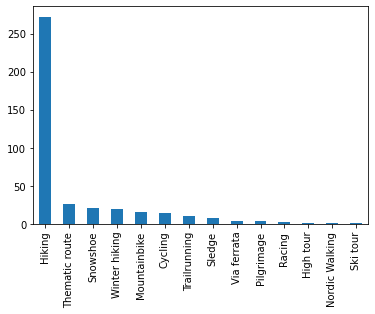

In [161]:
# Number of entries by types of sports
hikes_df['sport'].value_counts().plot(kind='bar')

In [162]:
# Creating a df for "Number of entries by sport type" + average tour length

sporttype = hikes_df.groupby('sport') \
       .agg({'sport':'count', 'length':'mean'}) \
       .rename(columns={'sport':'count','length':'average_length'}) \
       .reset_index()
sporttype

,sport,count,average_length
0,Cycling,15,30.284000
1,High tour,1,111.500000
2,Hiking,272,10.801360
3,Mountainbike,16,26.966250
4,Nordic Walking,1,4.880000
5,Pilgrimage,4,14.160000
6,Racing,2,51.455000
7,Ski tour,1,6.110000
8,Sledge,8,5.700000
9,Snowshoe,21,6.495714


In [163]:
# Difficulty

hikes_df['difficulty'].unique()

array(['medium', 'easy', 'difficult', ''], dtype=object)

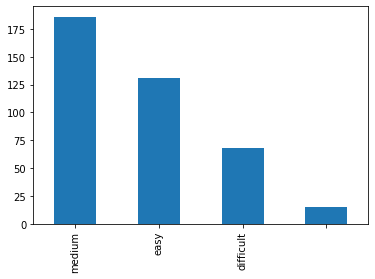

In [164]:
hikes_df['difficulty'].value_counts().plot(kind='bar')

In [165]:
# mean length for difficulty:

hikes_df.groupby('difficulty').mean()

,length,climb,min,max,technique,fitness
difficulty,,,,,,
,21.299333,1087.866667,985.133333,1784.466667,0.000000,0.000000
difficult,20.159118,1192.661765,1037.661765,2074.970588,3.176471,5.088235
easy,7.265649,208.366412,972.007634,1226.961832,1.427481,1.877863
medium,11.924624,557.290323,1084.403226,1648.440860,2.456989,3.349462


Text(0.5, 1.0, 'All activities')

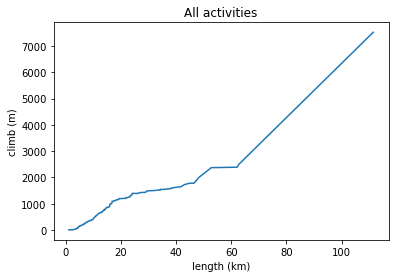

In [166]:
#df.reset_index().plot.scatter(x = 'index', y = 'value')
tour_len = sorted(pd.Series(hikes_df["length"]))
tour_climb = sorted(pd.Series(hikes_df["climb"]))
plt.plot(tour_len, tour_climb)
plt.ylabel('climb (m)')
plt.xlabel("length (km)")
plt.title('All activities')

In [167]:
## Creating a df for deeper analysis for Hiking
# Filter for hiking
hiking = hikes_df[hikes_df.sport == "Hiking"]

# calculating the count by Fitness level and the average length 
fitness_length = hiking.groupby('fitness') \
       .agg({'fitness':'count', 'length':'mean'}) \
       .rename(columns={'fitness':'count','length':'average_length'}) \
       .reset_index()

# calculating weighted and normalized length
fitness_length['weighted_ave_length'] = fitness_length["count"] * fitness_length["average_length"]
fitness_length["normalized_weighted_length"] = (fitness_length["weighted_ave_length"] - fitness_length["weighted_ave_length"].min()) \
                                                / (fitness_length["weighted_ave_length"].max() - fitness_length["weighted_ave_length"].min()) * 10
fitness_length


,fitness,count,average_length,weighted_ave_length,normalized_weighted_length
0,0,8,10.781250,86.25,0.634916
1,1,9,4.283333,38.55,0.000000
2,2,79,8.032658,634.58,7.933527
3,3,71,10.092113,716.54,9.024465
4,4,61,12.948033,789.83,10.000000
5,5,32,14.543125,465.38,5.681370
6,6,12,17.236667,206.84,2.240044


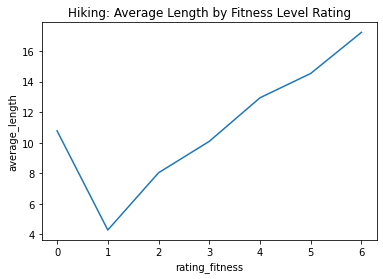

In [168]:
## Plotting Length vs. Fitness rating
#--> Conclusion: the routes with no fitness rating seems quite long. Investigate further

plt.plot(fitness_length["fitness"], fitness_length["average_length"])
plt.ylabel('average_length')
plt.xlabel("rating_fitness")
plt.title('Hiking: Average Length by Fitness Level Rating')

plt.show()

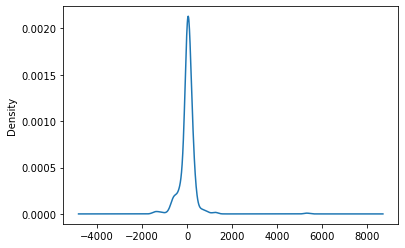

In [171]:
# quality checking data / or realizing we don't understand the columns?

hikes_df["residual"]= hikes_df["climb"] - (hikes_df["max"] - hikes_df["min"])
hikes_df["residual"].plot.density()